# Accessing Hydrology and Climatology database using web services through Python

**Taher Chegini**

**ESIP IT&I 2021**

<img src="https://raw.githubusercontent.com/cheginit/pangeo_showcase21/main/notebooks/logos.png" width="300"/>

In [1]:
from IPython.display import IFrame

IFrame(src="https://hyriver.readthedocs.io/en/latest", width=950, height=600)

## Showcase

1. Geometry data for plots: US states and coastlines
2. Tidal and Estuary USGS Stations
3. NHDPlus attributes for all stations
4. Accumulated Dams at catchment-scale for Columbia

### US States and Coastlines

**Census TIGER (Topologically Integrated Geographic Encoding and Referencing database)**

In [2]:
import warnings
from pathlib import Path

warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")
root = Path("..", "data")
root.mkdir(parents=True, exist_ok=True)
BASE_PLOT = {"facecolor": "k", "edgecolor": "b", "alpha": 0.2, "figsize": (18, 9)}
CRS = "esri:102008"

In [3]:
import geopandas as gpd
from shapely.geometry import box

conus_bounds = box(-125, 24, -65, 50)
cfile = Path(root, "conus.feather")

if cfile.exists():
    conus = gpd.read_feather(cfile)
else:
    tiger_url = (
        lambda x: f"https://www2.census.gov/geo/tiger/TIGER2020/{x.upper()}/tl_2020_us_{x}.zip"
    )
    coastline = gpd.read_file(tiger_url("coastline"))
    state = gpd.read_file(tiger_url("state"))
    conus = state[state.intersects(conus_bounds)].copy()
    conus_coastline = coastline[coastline.within(conus_bounds)]
    conus["coastal"] = conus.intersects(conus_coastline.unary_union)
    conus.to_feather(cfile)

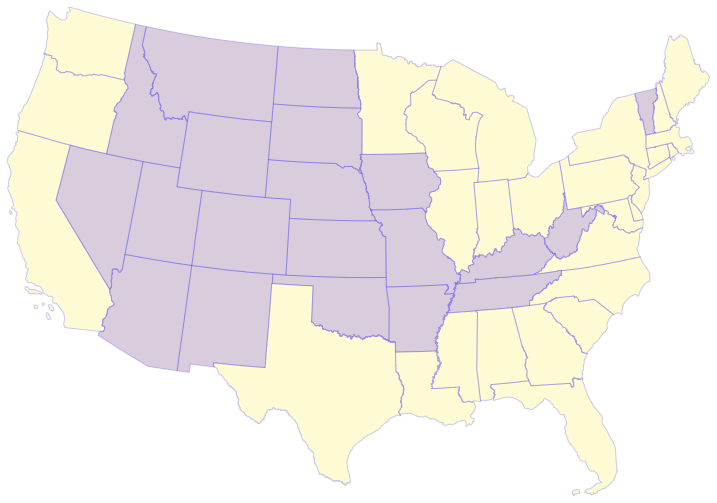

In [4]:
ax = conus.to_crs(CRS).plot(column="coastal", **BASE_PLOT)
ax.axis("off")
ax.margins(0)

### Tidal and Estuary USGS stations

<img src="https://raw.githubusercontent.com/cheginit/HyRiver-examples/main/notebooks/_static/pygeohydro_logo.png" width="400"/>

We need to look at the [Water Services](https://waterservices.usgs.gov/rest/Site-Service.html) API.

In [5]:
import pygeohydro as gh

nwis = gh.NWIS()
cfile = Path(root, "coast_stations.feather")
if cfile.exists():
    coast_stations = gpd.read_feather(cfile)
else:
    queries = [
        {
            "stateCd": s.lower(),
            "siteType": "ST-TS,ES",
            "hasDataTypeCd": "dv",
            "outputDataTypeCd": "dv",
        }
        for s in conus.loc[conus.coastal, "STUSPS"]
    ]

    sites = nwis.get_info(queries, False)
    coast_stations = gpd.GeoDataFrame(
        sites,
        geometry=gpd.points_from_xy(sites.dec_long_va, sites.dec_lat_va),
        crs="epsg:4269",
    )
    coast_stations.to_feather(cfile)

In [6]:
st = coast_stations[["site_no", "site_tp_cd", "geometry"]].to_crs(CRS)
ts = st[st.site_tp_cd == "ST-TS"].drop_duplicates()
es = st[st.site_tp_cd == "ES"].drop_duplicates()
station_ids = ts.site_no.tolist() + es.site_no.tolist()

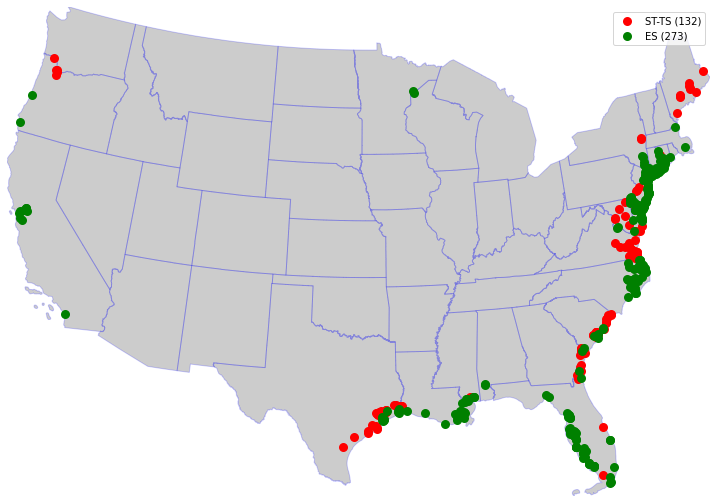

In [7]:
ax = conus.to_crs(CRS).plot(**BASE_PLOT)
ts.plot(ax=ax, lw=3, c="r")
es.plot(ax=ax, lw=3, c="g")
ax.legend([f"ST-TS ({ts.shape[0]})", f"ES ({es.shape[0]})"], loc="best")
ax.axis("off")
ax.margins(0)

### Mean daily discharge for all stations

In [8]:
import numpy as np
import pandas as pd

cfile = Path(root, "discharge.parquet")
dates = ("2000-01-01", "2015-12-31")

if cfile.exists():
    discharge = pd.read_parquet(cfile)
else:
    nwis = gh.NWIS()
    discharge = nwis.get_streamflow(
        station_ids,
        dates,
    )
    discharge[discharge < 0] = np.nan
    discharge.to_parquet(cfile)

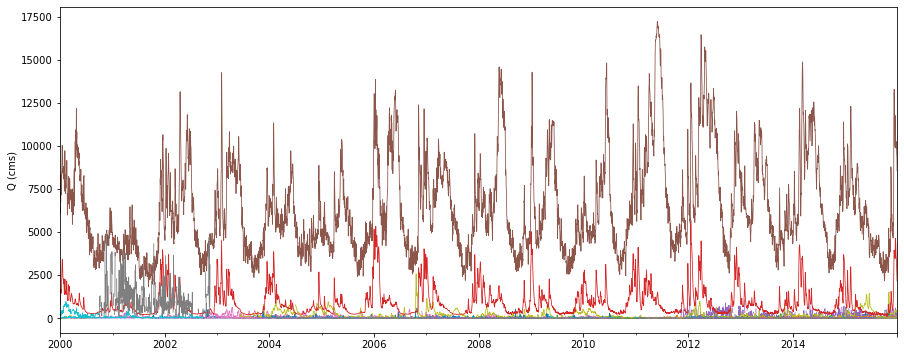

In [9]:
ax = discharge.plot(legend=False, lw=0.8, figsize=(15, 6))
ax.set_ylabel("Q (cms)")
ax.set_xlabel("")
ax.margins(x=0)

### River network data

<img src="https://raw.githubusercontent.com/cheginit/HyRiver-examples/main/notebooks/_static/pynhd_logo.png" width="400"/>


#### Main river network

In [10]:
import pynhd as nhd

nldi = nhd.NLDI()

In [11]:
from pygeoogc import ZeroMatched
from rich.progress import Progress

cfiles = list(Path(root).glob("flowline_main_*.feather"))
if all(c.exists() for c in cfiles):
    flws_main = {f.stem.rsplit("_", 1)[-1]: gpd.read_feather(f) for f in cfiles}
else:
    with Progress() as progress:
        task = progress.add_task("Main Flowlines", total=len(station_ids))
        for s in station_ids:
            cfile = Path(root, f"flowline_main_{s}.feather")
            if cfile.exists():
                progress.update(task, description=f"ID: {s:<19}", advance=1)
                continue
            try:
                flws_main = nldi.navigate_byid(
                    fsource="nwissite",
                    fid=f"USGS-{s}",
                    navigation="upstreamMain",
                    source="flowlines",
                    distance=2000,
                )
                flws_main.to_feather(cfile)
            except (ConnectionError, ZeroMatched):
                pass
            progress.update(task, description=f"{s:<15}", advance=1)

In [12]:
flws_main = (
    pd.concat(flws_main)
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "station"})
)
print(
    "\n".join(
        [
            f"No. of missing stations: {len(station_ids) - len(cfiles)}/{len(station_ids)}",
            f"No. of flowlines: {len(flws_main)}",
        ]
    )
)

No. of missing stations: 105/405
No. of flowlines: 21293


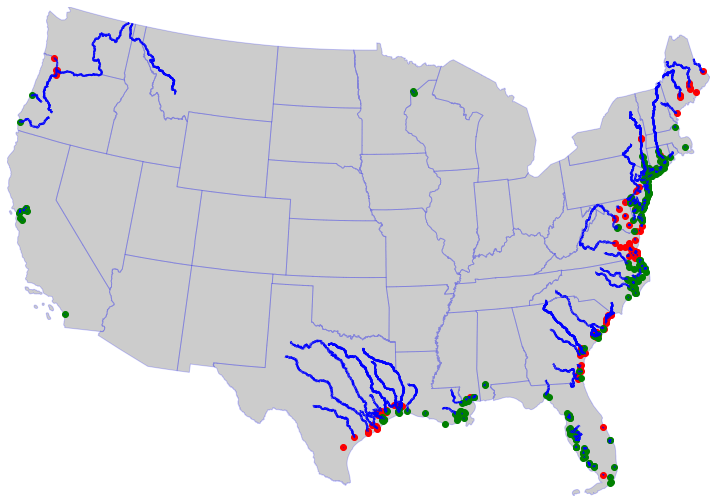

In [13]:
ax = conus.to_crs(CRS).plot(**BASE_PLOT)
ts.plot(ax=ax, lw=1, c="r")
es.plot(ax=ax, lw=1, c="g")
flws_main.to_crs(CRS).plot(ax=ax, lw=2, color="b")
ax.axis("off")
ax.margins(0)

#### Dams in upstream drainage area

In [ ]:
import pickle

cfile = Path(root, "nid_flw.pkl")

if cfile.exists():
    with open(cfile, "rb") as f:
        nid_flw = pickle.load(f)
else:
    meta = nhd.nhdplus_attrs()
    nid_years = (
        meta[meta.description.str.contains("dam", case=False)].sort_values("name").name.tolist()
    )
    nid_flw = {n.split("_")[-1]: nhd.nhdplus_attrs(n) for n in nid_years}
    with open(cfile, "wb") as f:
        pickle.dump(nid_flw, f)

In [ ]:
comids = [int(c) for c in flws_main.nhdplus_comid.tolist()]

nid_vals = {
    yr: df.loc[df.COMID.isin(comids), ["COMID", f"ACC_NID_STORAGE{yr}", f"ACC_NDAMS{yr}"]].rename(
        columns={
            "COMID": "comid",
            f"ACC_NID_STORAGE{yr}": "smax",
            f"ACC_NDAMS{yr}": "ndams",
        }
    )
    for yr, df in nid_flw.items()
}
nid_vals = pd.concat(nid_vals).reset_index().drop(columns="level_1")
nid_vals = nid_vals.rename(columns={"level_0": "year"}).astype({"year": int})

In [ ]:
nid_vals = nid_vals.set_index("comid").merge(
    flws_main.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
    left_index=True,
    right_index=True,
    suffixes=(None, None),
)
nm = len(station_ids) - len(nid_vals.station.unique())
print(f"No. of missing stations: {nm}/{len(station_ids)}")

#### Mean Annual Discharge

In [ ]:
import cytoolz as tlz

queries = [
    {
        "sites": ",".join(ss),
        "startDT": 1930,
        "endDT": 2013,
        "statReportType": "annual",
        "statTypeCd": "mean",
        "missingData": "on",
        "parameterCd": "00060",
    }
    for ss in tlz.partition_all(10, station_ids)
]

q_yr = nwis.retrieve_rdb("stat", queries).astype({"year_nu": int, "mean_va": float})
q_yr = (
    q_yr.sort_values("year_nu")[["year_nu", "site_no", "mean_va"]]
    .reset_index(drop=True)
    .rename(columns={"year_nu": "year", "site_no": "station", "mean_va": "q"})
)
nm = len(station_ids) - len(q_yr.station.unique())
print(f"No. of missing stations: {nm}/{len(station_ids)}")

In [ ]:
import matplotlib.pyplot as plt

smax = nid_vals.groupby(["year", "station"]).sum()["smax"].unstack()
q = q_yr.set_index(["year", "station"])["q"].unstack()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
smax.plot(ax=axs[0], legend=False)
axs[0].set_ylabel("$S_{max}$ (acre-feet)")
axs[0].margins(x=0)

q.plot(ax=axs[1], legend=False)
axs[1].set_ylabel("$Q_{mean}$ (cfs)")
axs[1].margins(x=0)

### Columbia River

In [ ]:
ax = conus.to_crs(CRS).plot(**BASE_PLOT)
ts.plot(ax=ax, lw=1, c="r")
es.plot(ax=ax, lw=1, c="g")
flws_main.to_crs(CRS).plot(ax=ax, lw=2, color="b")
ax.axis("off")
ax.margins(0)

#### Basin

In [ ]:
station_id = "14246900"
cfile = Path(root, "basin.feather")
if cfile.exists():
    basin = gpd.read_feather(cfile)
else:
    basin = nldi.get_basins(station_id)
    basin.to_feather(cfile)

#### Main

In [ ]:
cfile = Path(root, "flowline_main.feather")
if cfile.exists():
    flw_main = gpd.read_feather(cfile)
else:
    flw_main = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamMain",
        source="flowlines",
        distance=2000,
    )
    flw_main.to_feather(cfile)

#### Tributaries

In [ ]:
cfile = Path(root, "flowline_trib.feather")
if cfile.exists():
    flw_trib = gpd.read_feather(cfile)
else:
    flw_trib = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamTributaries",
        source="flowlines",
        distance=2000,
    )
    flw_trib.to_feather(cfile)
flw_trib["nhdplus_comid"] = flw_trib["nhdplus_comid"].astype("float").astype("Int64")

In [ ]:
ax = basin.plot(**BASE_PLOT)
flw_trib.plot(ax=ax)
flw_main.plot(ax=ax, lw=3, color="r")
ax.legend(["Tributaries", "Main"])
ax.axis("off")
ax.margins(0)

#### Accumulated Dams

In [ ]:
comids = [int(c) for c in flw_trib.nhdplus_comid.tolist()]
nid_vals = {
    yr: df.loc[df.COMID.isin(comids), ["COMID", f"ACC_NID_STORAGE{yr}", f"ACC_NDAMS{yr}"]].rename(
        columns={
            "COMID": "comid",
            f"ACC_NID_STORAGE{yr}": "smax",
            f"ACC_NDAMS{yr}": "ndams",
        }
    )
    for yr, df in nid_flw.items()
}
nid_vals = pd.concat(nid_vals).reset_index().drop(columns="level_1")
nid_vals = nid_vals.rename(columns={"level_0": "year"}).astype({"year": int})

#### Accumulated Max Storage

In [ ]:
nid_vals = (
    nid_vals.set_index("comid")
    .merge(
        flw_trib.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
        left_index=True,
        right_index=True,
        suffixes=(None, None),
    )
    .reset_index()
    .rename(columns={"index": "comid"})
)
smax = nid_vals.groupby(["year", "comid"]).sum()["smax"].unstack()
smax = gpd.GeoDataFrame(
    smax.T.merge(
        flw_trib.astype({"nhdplus_comid": int}).set_index("nhdplus_comid"),
        left_index=True,
        right_index=True,
        suffixes=(None, None),
    )
)

In [ ]:
yr = 2013
ax = basin.plot(**BASE_PLOT)
smax.plot(ax=ax, scheme="Quantiles", k=2, column=yr, cmap="coolwarm", lw=0.5, legend=False)
ax.set_title(f"Accumulated Maximum Storage Capacity of Dams up to {yr}")
ax.axis("off")
ax.margins(0)